In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit, root_scalar
import json
import matplotlib.pyplot as plt
import math

### Mapping Win % To Estimated Draft Pick

Load 30 seasons worth of data mapping wins (out of 82) to record rank (out of 30)

In [2]:
f = open('data.json')
wins_to_pick_data = json.load(f)
print(wins_to_pick_data[0:5])

[{'won': 27, 'pick': 1}, {'won': 27, 'pick': 2}, {'won': 29, 'pick': 3}, {'won': 30, 'pick': 4}, {'won': 31, 'pick': 5}]


We attempt to build 2 models: one that will work for the default settings (82 games, 30 teams) to prove that win% can be accurately approximated into draft position, and another that will take win % and a scaled version of draft position from 0 to 1 so that it can be adjusted based on # of teams/games

In [3]:
wins = list(map(lambda o: o['won'], wins_to_pick_data))
picks = list(map(lambda o: o['pick'], wins_to_pick_data))
wins_p = list(map(lambda o: o['won']/82, wins_to_pick_data))
picks_p = list(map(lambda o: o['pick']/30, wins_to_pick_data))

We see that the wins curve over time models an S shape aka the [sigmoid curve](https://en.wikipedia.org/wiki/Sigmoid_function): highly concentrated in the middle where small deltas lead to large differences in pick, but convergent near the endpoints

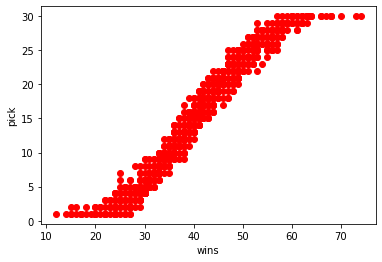

In [4]:
plt.plot(wins, picks, 'ro')
plt.xlabel('wins')
plt.ylabel('pick')
plt.show()

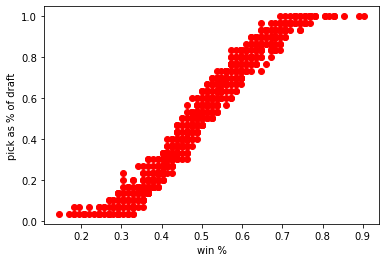

In [5]:
plt.plot(wins_p, picks_p, 'ro')
plt.xlabel('win %')
plt.ylabel('pick as % of draft')
plt.show()

We attempt to model this curve using a scaled version of the most common sigmoid function, the [logistic function](https://en.wikipedia.org/wiki/Logistic_function)

In [6]:
#https://stackoverflow.com/questions/55725139/fit-sigmoid-function-s-shape-curve-to-data-using-python
def sigmoid(x, L ,x0, k, b):
    y = L / (1 + np.exp(-k*(x-x0))) + b
    return (y)

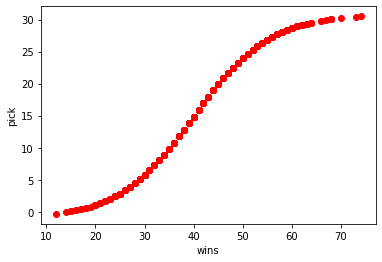

In [7]:
p0 = [29, 15,1/82,1]
(a_0, b_0, c_0, d_0), pcov = curve_fit(sigmoid, wins,picks,p0, method='dogbox')
pick_ests = sigmoid(wins, a_0, b_0, c_0, d_0)
plt.plot(wins, pick_ests, 'ro')
plt.xlabel('wins')
plt.ylabel('pick')
plt.show()

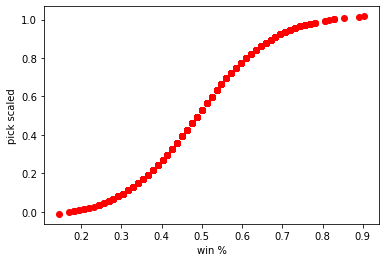

In [8]:
p1 = [1, 0.5,1,0]
(a_1, b_1, c_1, d_1), pcov = curve_fit(sigmoid, wins_p , picks_p,p1, method='dogbox')
picks_p_ests = sigmoid(wins_p, a_1, b_1, c_1, d_1)
plt.plot(wins_p , picks_p_ests, 'ro')
plt.xlabel('win %')
plt.ylabel('pick scaled')
plt.show()

In [47]:
print(a_1)
print(b_1)
print(c_1)
print(d_1)

1.0687820005007198
0.4878517508315021
10.626956987806935
-0.038756647038824504


To show a more readable version of what this function, here is a map from pick to how many wins a team would need to have to be approximated for that pick

In [46]:
pick_info = dict([(1, [15,25]), (3, [20,30]), (5, [25,35]), (10, [30,40]), (15, [35,45]), (20, [40,50]), (25, [50,60]), (27, [50,70]), (30, [60,80])])
picks_to_wins = {key:int(root_scalar(lambda x: sigmoid(x, a_0, b_0, c_0,d_0)-key, bracket=value).root) for (key,value) in pick_info.items()}
for pick, w in picks_to_wins.items():
    print(f"Pick {pick}: {w} wins")

Pick 1: 19 wins
Pick 3: 25 wins
Pick 5: 28 wins
Pick 10: 35 wins
Pick 15: 40 wins
Pick 20: 45 wins
Pick 25: 51 wins
Pick 27: 55 wins
Pick 30: 67 wins


Some tests to reference to check that JS version is calculating accurately

In [42]:
print("30 wins maps to: " + sigmoid(30/82, a_1, b_1, c_1, d_1)*30)
print("40 wins maps to: " + sigmoid(40/82, a_1, b_1, c_1, d_1)*30)
print("50 wins maps to: "+ sigmoid(50/82, a_1, b_1, c_1, d_1)*30)

5.723248172520302
14.865037773464492
24.009424752100028


We attempt a cubic fit to show why the sigmoid function by itself is a better approximation: the cubic function works well between 20 and 60 wins, which is probably >97% of cases, but doesn't model the behavior accurately for extreme cases like 10 wins or 70 wins. The solution, if we want to use cubic in the case that's easier to understand when others have to work with it, is you could say something like (if wins < 17 assume pick = 1, if wins > 63 assume pick = 30). 

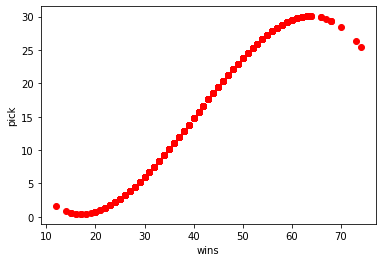

In [12]:
z_0 = np.polyfit(wins, picks, 3)
poly_0 = np.poly1d(z_0)
pick_ests_cubic = list(map(lambda x: poly_0(x), wins))
plt.plot(wins, pick_ests_cubic, 'ro')
plt.xlabel('wins')
plt.ylabel('pick')
plt.show()

To find, where the cubic fit stops being accurate, it's where slope = 0. 
Derivative of $\frac{d}{dx}(fx^3 + gx^2 + hx + i) = 3fx^2 + 2gx + h$

The quadratic sols then are
$\frac{-2g + \sqrt{4g^2 - 12fh}}{6f}$
and 
$\frac{-2g - \sqrt{4g^2 - 12fh}}{6f}$

We can basically say for *this specific* distribution, if wins <= 17 assume worst team, if >= 64 assume best team

In [13]:
lower_bound_cubic = (-2 * z_0[1] - math.sqrt(4*z_0[1]**2 - 12 * z_0[0] * z_0[2]))/(6 * z_0[0])
upper_bound_cubic = (-2 * z_0[1] + math.sqrt(4*z_0[1]**2 - 12 * z_0[0] * z_0[2]))/(6 * z_0[0])
print(upper_bound_cubic)
print(lower_bound_cubic)

17.08524616618224
63.952159398853084


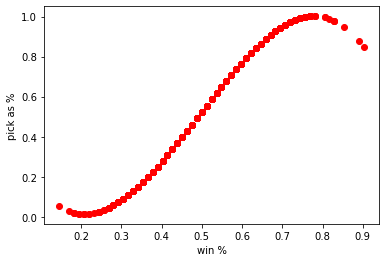

In [14]:
z_1 = np.polyfit(wins_p, picks_p, 3)
poly_1 = np.poly1d(z_1)
pick_p_ests_cubic = list(map(lambda x: poly_1(x), wins_p))
plt.plot(wins_p, pick_p_ests_cubic, 'ro')
plt.xlabel('win %')
plt.ylabel('pick as %')
plt.show()

### Mapping Team Rating to a Win %

Read about ten seasons worth of team rating data

In [25]:
f2 = open('ratings.json')
team_rating_data = json.load(f2)
print(team_rating_data)

[[32, 34, 36, 40, 40, 40, 41, 42, 45, 45, 49, 51, 51, 52, 52, 53, 55, 55, 56, 58, 60, 62, 62, 63, 63, 66, 69, 69, 70, 71], [37, 38, 40, 42, 42, 43, 43, 44, 44, 45, 45, 45, 48, 48, 50, 50, 50, 51, 53, 53, 54, 55, 55, 55, 58, 64, 65, 67, 72, 76], [29, 30, 33, 33, 34, 34, 42, 42, 42, 42, 42, 43, 45, 47, 48, 48, 49, 54, 55, 56, 56, 59, 60, 61, 62, 65, 68, 72, 73, 73], [15, 34, 34, 37, 37, 38, 40, 41, 41, 42, 44, 44, 44, 46, 50, 50, 50, 51, 51, 52, 54, 58, 59, 61, 63, 63, 63, 67, 68, 71], [19, 22, 31, 34, 36, 37, 39, 39, 40, 41, 42, 43, 45, 46, 47, 47, 48, 50, 51, 53, 55, 56, 60, 62, 65, 66, 67, 68, 73, 78], [36, 36, 37, 38, 38, 39, 41, 42, 42, 43, 46, 47, 47, 48, 49, 50, 52, 54, 54, 59, 60, 60, 61, 63, 64, 64, 66, 68, 74, 77], [19, 24, 25, 32, 36, 36, 38, 41, 42, 43, 44, 46, 49, 49, 51, 52, 53, 53, 58, 59, 59, 61, 62, 63, 65, 65, 69, 71, 75, 82], [24, 34, 34, 34, 35, 35, 38, 39, 39, 42, 42, 46, 47, 48, 48, 48, 51, 53, 53, 55, 56, 57, 63, 63, 66, 67, 69, 75, 78, 82], [21, 28, 31, 32, 33, 36

Sample distribution of one season's ratings

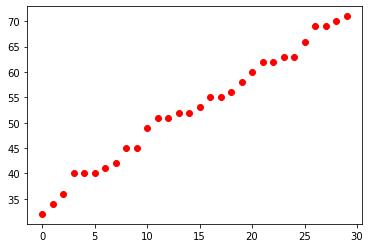

In [26]:
plt.plot(team_rating_data[0], 'ro')

Distribution of all team ratings across 10 years, indicates this data also follows more of a cubic/S-shaped distribution than a pure linear one

In [27]:
team_rating_ranks = [[30 - i for i in range(len(l))] for l in team_rating_data]

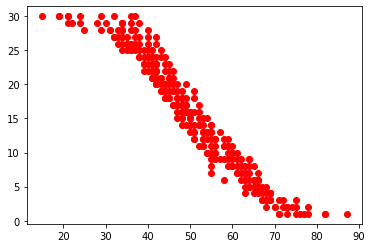

In [28]:
all_rating_data = [r for l in team_rating_data for r in l]
all_tr_ranks = [r for l in team_rating_ranks for r in l]
plt.plot(all_rating_data, all_tr_ranks,'ro')

Distribution of all team across 3 years

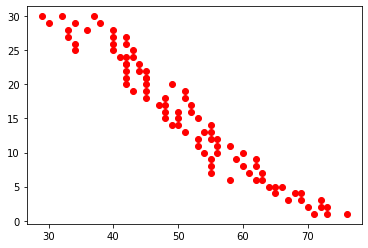

In [30]:
some_rating_data = [r for l in team_rating_data[0:3] for r in l]
some_tr_ranks = [r for l in team_rating_ranks[0:3] for r in l]
plt.plot(some_rating_data, some_tr_ranks,'ro')

So the thing about these distributions is there could be a lot of variance not only across different leagues with different settings but also across different seasons in the same league. We would want to dynamically generate a fit at the beginning of each season for a given league that maps from team rating to team rank. 

For that reason, more data is necessarily "better" in that case, as we want to accurately model the distribution of the league in the present. Using 1-3 seasons of team rating data rather than all would likely lead to a more accurate approximation.

So we fit a curve on the data across 3 seasons to try and approximate a mapping from team rating to team rank

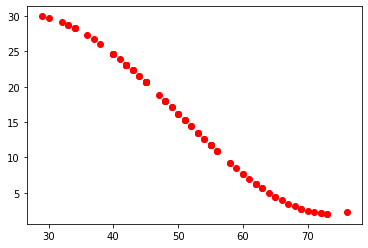

In [31]:
z_2 = np.polyfit(some_rating_data, some_tr_ranks, 3)
p_2 = np.poly1d(z_2)
some_tr_rank_fit_cubic = list(map(lambda x: p_2(x), some_rating_data))
plt.plot(some_rating_data, some_tr_rank_fit_cubic, 'ro')

To find, where the cubic fit stops being accurate, it's where slope = 0. 
Derivative of $fx^3 + gx^2 + hx + i$ is
$3fx^2 + 2gx + h$

The quadratic sols then are
$\frac{-2g + \sqrt{4g^2 - 12fh}}{6f}$
and 
$\frac{-2g - \sqrt{4g^2 - 12fh}}{6f}$

We can basically say for *this specific* distribution, if ovr < 22 assume worst team, if > 78 assume best team

In [32]:
lower_bound_cubic_2 = (-2 * z_2[1] - math.sqrt(4*z_2[1]**2 - 12 * z_2[0] * z_2[2]))/(6 * z_2[0])
upper_bound_cubic_2 = (-2 * z_2[1] + math.sqrt(4*z_2[1]**2 - 12 * z_2[0] * z_2[2]))/(6 * z_2[0])
print(lower_bound_cubic_2)
print(upper_bound_cubic_2)

26.805243041733473
73.47194186464876


We try a linear fit as well to see if that models it as well as a cubic (it's possible it does)

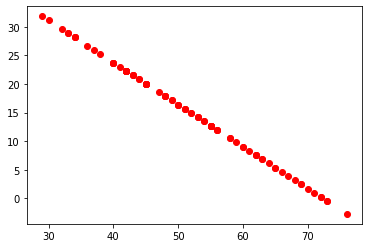

In [33]:
z_3 = np.polyfit(some_rating_data, some_tr_ranks, 1)
p_3 = np.poly1d(z_3)
some_tr_rank_fit_linear = list(map(lambda x: p_3(x), some_rating_data))
plt.plot(some_rating_data, some_tr_rank_fit_linear, 'ro')

We also try using only 1 season worth of data and how well it can be modeled.

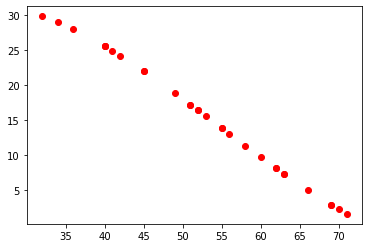

In [34]:
z_4 = np.polyfit(team_rating_data[0], team_rating_ranks[0], 3)
p_4 = np.poly1d(z_4)
one_tr_rank_fit_cubic = list(map(lambda x: p_4(x), team_rating_data[0]))
plt.plot(team_rating_data[0], one_tr_rank_fit_cubic, 'ro')

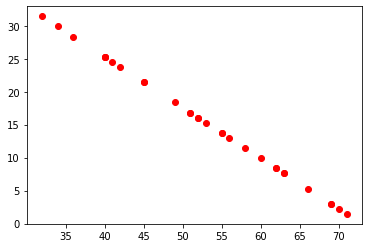

In [35]:
z_5 = np.polyfit(team_rating_data[0], team_rating_ranks[0], 1)
p_5 = np.poly1d(z_5)
one_tr_rank_fit_linear = list(map(lambda x: p_5(x), team_rating_data[0]))
plt.plot(team_rating_data[0], one_tr_rank_fit_linear, 'ro')